<h1><center><font color=darkcyan> Strategy: Price-momentum on a single stock </font></center></h1>

<h2><center><font color=darkblue> Page 40 </font></center></h2>

<lu>
    <li><font color=darkblue> Lionel SOPGOUI MBEUKAM</font></li
</lu>
<hr>

In [1]:
import numpy as np
import time
import os
import random
from numba import njit, guvectorize, float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import yfinance as yf 
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
def read_file(folder):
    print(folder)
    l = os.listdir(folder)
    nasdaq_open = pd.read_csv(folder+'/'+l[0], index_col = [0])

    for l_ in l:
        ndx = pd.read_csv(folder+'/'+l_, index_col = [0])
        nasdaq_open[ndx.columns] = ndx

    return nasdaq_open

We implement here a liquidity measure of our stocks

In [3]:
def compute_LIX(up, dw, vol, pri):
    df = vol * pri / (up - dw)
    df = df.apply(np.log10)
    df = pd.DataFrame(df.mean())
    return df

In [4]:
def prepare_file(n=50):
    folder = "Data/"
    nasdaq_open = pd.read_csv(folder+"Open_2023-05-03.csv", index_col = [0])
    nasdaq_close = pd.read_csv(folder+"Close_2023-05-03.csv", index_col = [0])
    nasdaq_Volume = pd.read_csv(folder+"Volume_2023-05-03.csv", index_col = [0])
    nasdaq_High = pd.read_csv(folder+"High_2023-05-03.csv", index_col = [0])
    nasdaq_Low = pd.read_csv(folder+"Low_2023-05-03.csv", index_col = [0])

    nasdaq_open = nasdaq_open.dropna(axis = 1)
    cols = list(nasdaq_open.columns)
    nasdaq_close = nasdaq_close[cols].dropna(axis = 1)
    nasdaq_High = nasdaq_High[cols].dropna(axis = 1)
    nasdaq_Low = nasdaq_Low[cols].dropna(axis = 1)
    nasdaq_Volume = nasdaq_Volume[cols].dropna(axis = 1)
    print("before LIX = ", nasdaq_open.shape)

    LIX = compute_LIX(nasdaq_High, nasdaq_Low, nasdaq_Volume, nasdaq_close)
    LIX = LIX[~LIX.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    LIX = LIX.sort_values([0],  ascending=False)
    cols = list(LIX[LIX[0] > LIX.mean()[0]].index)
    random.shuffle(cols)
    cols = cols[:n]

    Open_ = nasdaq_open[cols].dropna(axis = 1)
    Close_ = nasdaq_close[cols].dropna(axis = 1)
    High_ = nasdaq_High[cols].dropna(axis = 1)
    Low_ = nasdaq_Low[cols].dropna(axis = 1)
    Volume_ = nasdaq_Volume[cols].dropna(axis = 1)
    
    print("after LIX = ", Open_.shape)
    
    return Open_, Close_, High_, Low_, Volume_, cols

Open, Close, High, Low, Volume, cols = prepare_file()

m, n = Open.shape

before LIX =  (839, 3104)
after LIX =  (839, 50)


C:\Users\maixe\AppData\Local\Temp\ipykernel_23432\2253966095.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  LIX = LIX[~LIX.isin([np.nan, np.inf, -np.inf]).any(1)]


In [5]:
def plot_some_stocks(data, label, m = 4, data2 = None, label2 = None):
    cols = data.columns
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(m):
        data[cols[i]].plot(ax = axes[i], label=label, title=cols[i])
        if data2 is not None:
            data2[cols[i]].plot(ax = axes[i], label=label2, title=cols[i])
        axes[i].legend()
    plt.tight_layout()
    plt.show()

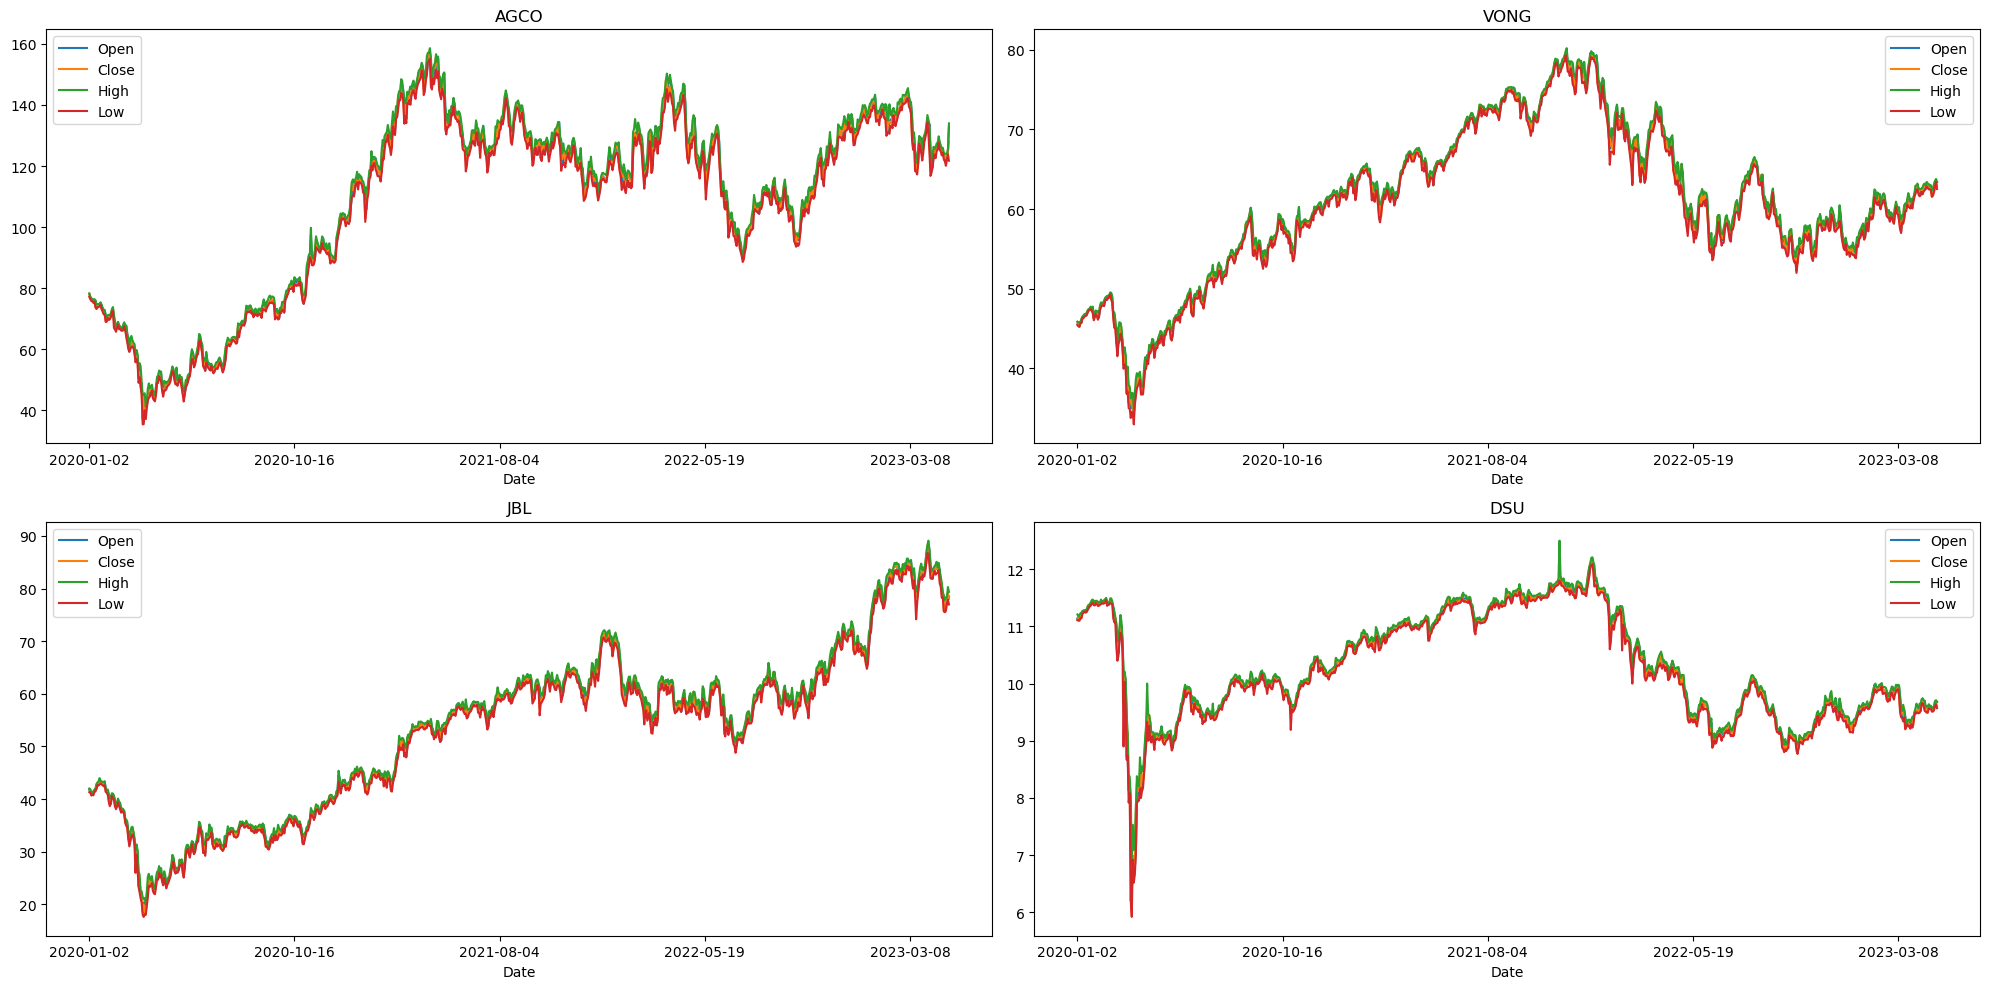

In [6]:
m = 4
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
axes = axes.flatten()

for i in range(m):
    Open[cols[i]].plot(ax = axes[i], label="Open")
    Close[cols[i]].plot(ax = axes[i], label="Close")
    High[cols[i]].plot(ax = axes[i], label="High")
    Low[cols[i]].plot(ax = axes[i], label="Low", title=cols[i])
    axes[i].legend()
plt.tight_layout()
plt.show()

$$ R_t = \frac{P_t}{P_{t-1}} - 1 \qquad R_t^{cum} = \frac{1}{T} \sum_{s=1}^{T} R_{t+s} \qquad R_t^{mean} = \frac{R_t^{cum}}{T} \qquad R_t^{R_risk.adj} = \frac{R_t^{mean}}{\sqrt{\frac{1}{T} \sum_{s=1}^{T} (R_{t+s}-R_t^{mean})^2}},$$
where 
- If $P_t$ is the stock price at $t$
- If $R_t$ is the stock return at $t$
- If $R_t^{cum}$ is the stock cumulative return at $t$
- If $R_t^{mean}$ is the stock average return at $t$
- If $R_t^{R_risk.adj}$ is the stock average return risk ajusted at $t$

In [7]:
def compute_quantities(data, T = 25, criterium = None):
    R_i_t = 100*data.pct_change().dropna()  
    #pd.DataFrame(data.iloc[:-1].values / data.iloc[1:].values - 1, 
     #                    columns = data.columns, index = data.index[1:])
    
    if criterium == "R_cum":
        R = R_i_t.rolling(window=T).sum()
    elif criterium == "R_mean":
        R = R_i_t.rolling(window=T).mean()
    elif criterium == "R_risk.adj":
        sigma = R_i_t.rolling(window=T).std()
        R_mean = R_i_t.rolling(window=T).mean()
        R = R_mean / sigma
    else:
        return R_i_t
    return R

In [8]:
col = cols[0]
R_mean = compute_quantities(Close[[col]], T = 25, criterium = "R_mean")
R_cum = compute_quantities(Close[[col]], T = 25, criterium = "R_cum")
R_risk = compute_quantities(Close[[col]], T = 25, criterium = "R_risk.adj")
R = compute_quantities(Close[[col]], T = 25)

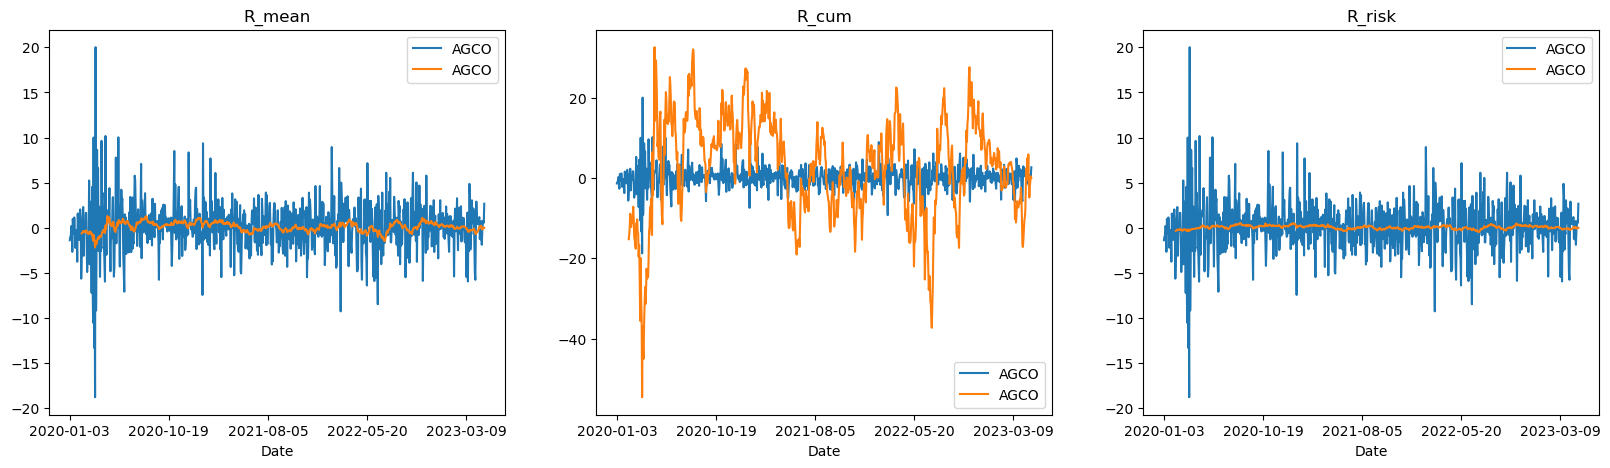

In [9]:
m = 4
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
axes = axes.flatten()

R.plot(ax = axes[0], title = 'Return')
R.plot(ax = axes[1], title = 'Return')
R.plot(ax = axes[2], title = 'Return')
R_mean.plot(ax = axes[0], title = 'R_mean')
R_cum.plot(ax = axes[1], title = 'R_cum')
R_risk.plot(ax = axes[2], title = 'R_risk')

plt.show()

We work on a self-financed portfolio. We fix our initial wealth and we run a momuntum strategy: At each time,
- if the rolling criterium is less than the current return, we sell all the stock and we keep our cash
- if not, 
    - if there is a cash, we use all to buy the equivalent quantity of stocks
    - if not, nothing.
    
At each time, we keep the quantity of cash in the portfolio.

In [10]:
def momentum(prices, criterium, capital = 1000, T = 30):
    returns = prices.pct_change()
    #rolling_mean = returns.rolling(window=T).sum()
    
    if criterium == "R_cum":
        rolling_mean = returns.rolling(window=T).sum()
    elif criterium == "R_mean":
        rolling_mean = returns.rolling(window=T).mean()
    elif criterium == "R_risk.adj":
        sigma = returns.rolling(window=T).std()
        R_mean = returns.rolling(window=T).mean()
        rolling_mean = R_mean / sigma

        
    data = pd.DataFrame(index = returns.index, 
                            columns = ["quantity", "wealth"])
    data.iloc[0] = [capital/prices.iloc[0][prices.columns[0]], capital]
    buying_power = 0.
    for t in range(1, T+1):
        data.iloc[t] = [data.iloc[t-1]["quantity"], 
                        data.iloc[t-1]["quantity"] * prices.iloc[t][prices.columns[0]]]
        
    for t in range(T+1, len(prices)):
        #print(rolling_mean.iloc[t][prices.columns[0]], returns.iloc[t][prices.columns[0]])
        if rolling_mean.iloc[t][prices.columns[0]] < returns.iloc[t][prices.columns[0]]:
            if data.iloc[t-1]["quantity"] != 0:
                #print(f"At {prices.index[t]}, sell {data.iloc[t-1]['quantity']} at {prices.iloc[t][prices.columns[0]]}")
                buying_power = data.iloc[t-1]["quantity"] * prices.iloc[t][prices.columns[0]]
                data.iloc[t] = [0., data.iloc[t-1]["quantity"] * prices.iloc[t][prices.columns[0]]]
            else:
                #print("Nothing to sell")
                data.iloc[t] = [0., buying_power]
        else:
            #print("BUY", buying_power)
            if buying_power > 0:
                data.iloc[t] = [buying_power/prices.iloc[t][prices.columns[0]], buying_power]
                buying_power = 0.
            else:
                data.iloc[t] = [data.iloc[t-1]["quantity"], 
                                data.iloc[t-1]["quantity"] * prices.iloc[t][prices.columns[0]]]
                
    return data, rolling_mean, returns

prices = Open[[cols[0]]]

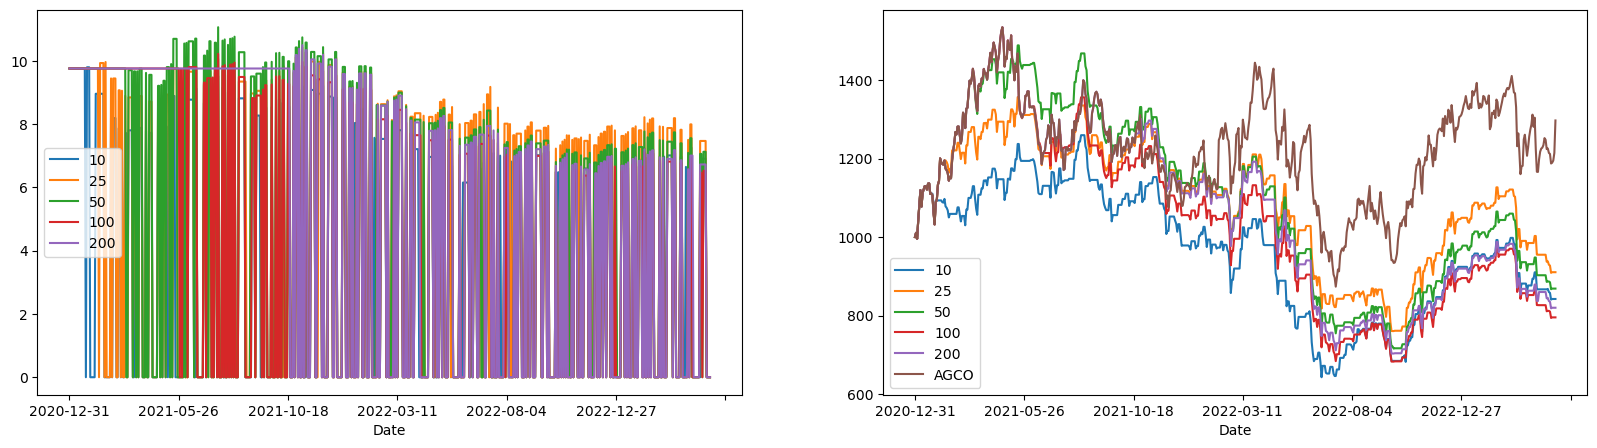

In [11]:
criterium = "R_mean"
data = {}
data["10"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 10)
data["25"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 25)
data["50"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 50)
data["100"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 100)
data["200"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 200)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axes = axes.flatten()

for key in list(data.keys()):
    data[key]["quantity"].plot(ax = axes[0], label=key)
    data[key]["wealth"].plot(ax = axes[1], label=key)

(data[key].iloc[0].quantity*prices.loc[data[key]["wealth"].index]).plot(ax = axes[1])
axes[0].legend()
axes[1].legend()
plt.show()

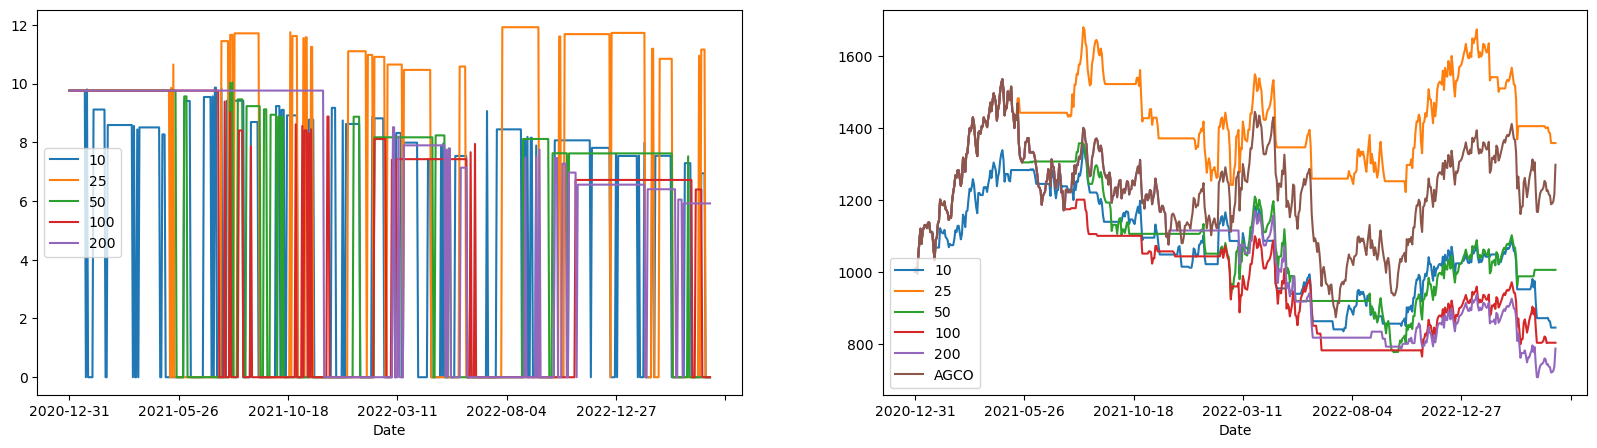

In [12]:
criterium = "R_cum"
data = {}
data["10"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 10)
data["25"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 25)
data["50"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 50)
data["100"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 100)
data["200"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 200)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axes = axes.flatten()

for key in list(data.keys()):
    data[key]["quantity"].plot(ax = axes[0], label=key)
    data[key]["wealth"].plot(ax = axes[1], label=key)

(data[key].iloc[0].quantity*prices.loc[data[key]["wealth"].index]).plot(ax = axes[1])
axes[0].legend()
axes[1].legend()
plt.show()

In [13]:
data["25"][["wealth"]].pct_change().describe()

,wealth
count,586.000000
mean,0.000693
std,0.018522
min,-0.084536
25%,-0.002414
50%,0.000000
75%,0.004684
max,0.109857


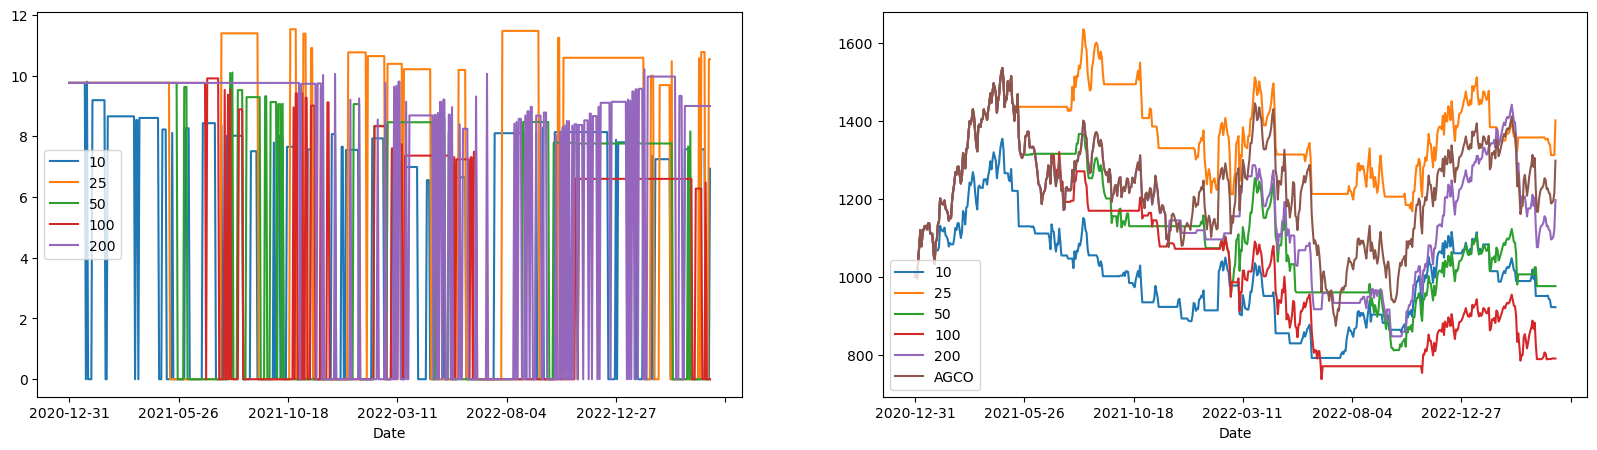

In [14]:
criterium = "R_risk.adj"
data = {}
data["10"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 10)
data["25"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 25)
data["50"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 50)
data["100"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 100)
data["200"], rolling_mean, returns = momentum(prices.iloc[252:], criterium, capital = 1000, T = 200)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axes = axes.flatten()

for key in list(data.keys()):
    data[key]["quantity"].plot(ax = axes[0], label=key)
    data[key]["wealth"].plot(ax = axes[1], label=key)

(data[key].iloc[0].quantity*prices.loc[data[key]["wealth"].index]).plot(ax = axes[1])
axes[0].legend()
axes[1].legend()
plt.show()

We run the strategy on 50 stocks over 2 years and we compute mean and stantard deviation of the returns and the sharpe ratio.

In [16]:
R = {}

keys = ["mean", "std", "sharpe"]
windows = [1, 10, 25, 50, 100, 200]

for key in keys:
    R[key] = pd.DataFrame(0., index = ["1d", "10d", "25d", "50d", "100d", "200d"],
                         columns = ["R_mean", "R_cum", "R_risk.adj"])
    
for col in cols:
        print(col)
        prices = Open[[col]]
        for i in range(len(windows)):
            idx = windows[i]
            print(i,windows[i])
            result_R_mean, _, _ = momentum(prices.iloc[252:], "R_mean", capital = 1000, T = idx)
            result_R_sum, _, _ = momentum(prices.iloc[252:], "R_cum", capital = 1000, T = idx)
            result_R_risk, _, _ = momentum(prices.iloc[252:], "R_risk.adj", capital = 1000, T = idx)
            
            R["mean"].iloc[i]["R_mean"] += 100*result_R_mean["wealth"].pct_change().iloc[1:].mean()
            R["mean"].iloc[i]["R_cum"] += 100*result_R_sum["wealth"].pct_change().iloc[1:].mean()
            R["mean"].iloc[i]["R_risk.adj"] += 100*result_R_risk["wealth"].pct_change().iloc[1:].mean()
            
            R["std"].iloc[i]["R_mean"] += 100*result_R_mean["wealth"].pct_change().iloc[1:].std()
            R["std"].iloc[i]["R_cum"] += 100*result_R_sum["wealth"].pct_change().iloc[1:].std()
            R["std"].iloc[i]["R_risk.adj"] += 100*result_R_risk["wealth"].pct_change().iloc[1:].std()
#"""
for i in range(len(windows)):
    R["mean"].iloc[i]["R_mean"] /= len(cols)
    R["mean"].iloc[i]["R_cum"] /= len(cols)
    R["mean"].iloc[i]["R_risk.adj"] /= len(cols)

    R["std"].iloc[i]["R_mean"] /= len(cols)
    R["std"].iloc[i]["R_cum"] /= len(cols)
    R["std"].iloc[i]["R_risk.adj"] /= len(cols)
    #""" 

AGCO
0 1
1 10
2 25
3 50
4 100
5 200
VONG
0 1
1 10
2 25
3 50
4 100
5 200
JBL
0 1
1 10
2 25
3 50
4 100
5 200
DSU
0 1
1 10
2 25
3 50
4 100
5 200
ESS
0 1
1 10
2 25
3 50
4 100
5 200
TECH
0 1
1 10
2 25
3 50
4 100
5 200
TRNO
0 1
1 10
2 25
3 50
4 100
5 200
UDR
0 1
1 10
2 25
3 50
4 100
5 200
CLF
0 1
1 10
2 25
3 50
4 100
5 200
TTMI
0 1
1 10
2 25
3 50
4 100
5 200
FTGC
0 1
1 10
2 25
3 50
4 100
5 200
ARES
0 1
1 10
2 25
3 50
4 100
5 200
CTSH
0 1
1 10
2 25
3 50
4 100
5 200
MUR
0 1
1 10
2 25
3 50
4 100
5 200
RES
0 1
1 10
2 25
3 50
4 100
5 200
CBAY
0 1
1 10
2 25
3 50
4 100
5 200
AU
0 1
1 10
2 25
3 50
4 100
5 200
MAA
0 1
1 10
2 25
3 50
4 100
5 200
VGLT
0 1
1 10
2 25
3 50
4 100
5 200
MS
0 1
1 10
2 25
3 50
4 100
5 200
PCAR
0 1
1 10
2 25
3 50
4 100
5 200
NYMT
0 1
1 10
2 25
3 50
4 100
5 200
LDOS
0 1
1 10
2 25
3 50
4 100
5 200
PHM
0 1
1 10
2 25
3 50
4 100
5 200
TNDM
0 1
1 10
2 25
3 50
4 100
5 200
VRSK
0 1
1 10
2 25
3 50
4 100
5 200
EFC
0 1
1 10
2 25
3 50
4 100
5 200
HES
0 1
1 10
2 25
3 50
4 100
5 200
SCCO
0 

In [17]:
R["mean"]

,R_mean,R_cum,R_risk.adj
1d,0.036252,0.036252,0.036252
10d,0.032810,0.013878,0.017004
25d,0.028423,0.016333,0.015031
50d,0.028916,0.006138,0.000209
100d,0.024162,0.019022,0.012704
200d,0.031908,0.024444,0.026460


In [18]:
R["std"]

,R_mean,R_cum,R_risk.adj
1d,2.378374,2.378374,2.378374
10d,1.743959,1.696349,1.687482
25d,1.768750,1.722584,1.719130
50d,1.834403,1.760510,1.764778
100d,1.892500,1.792417,1.812577
200d,1.967198,1.817458,1.853237


In [19]:
R["sortino"] = R["mean"]/R["std"]

R["sortino"]

,R_mean,R_cum,R_risk.adj
1d,0.015242,0.015242,0.015242
10d,0.018814,0.008181,0.010076
25d,0.016070,0.009482,0.008743
50d,0.015763,0.003486,0.000118
100d,0.012767,0.010612,0.007009
200d,0.016220,0.013449,0.014278


## END!